### <b><u>Step 1</u>: Import library</b>

These are the main libraries used for data analysis:
- `numpy`: used to get spotipy's client_id, secret and redirect uri in .env file
- `pandas`: used to get accessed to .env files in system
- `matplotlib`: used to support write data to csv files

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [165]:
df = pd.read_csv('../../data/artists_data.csv', sep='\t')
df.head()

,id,name,genres,followers,popularity
0,1LEtM3AleYg1xabW6CRkpi,Đen,"indie viet, v-pop, vietnamese hip hop, vietnam...",2899329,59
1,3rjcQ5VIWCN4q7UFetzdeO,JustaTee,"v-pop, vietnamese hip hop, vietnamese melodic rap",618216,55
2,5fa13NJjmn2uQ3dxZDi2Ge,Bich Phuong,v-pop,1182922,46
3,0qkGQFUrj8ERPAZcdpa79j,Phuc Du,v-pop,16509,46
4,71Cy7nzbfpuGJAS5FGxm93,Khoi Vu,vietnamese hip hop,25307,43


In [166]:
%store -r songs_df
%store -r songs_model_df

In [167]:
songs_df.head()

,id,name,artist,genres,artist_followers,artist_popularity,markets,album,released_date,album_popularity,duration,popularity,main_genre,artists_count
0,1RDvyOk4WtPCtoqciJwVn8,Dreamers [Music from the FIFA World Cup Qatar ...,"[Jung Kook, BTS, FIFA Sound]","[k-pop boy group, k-pop]",58961886,100,183,Dreamers [Music from the FIFA World Cup Qatar ...,2022-11-20,81,201391,92,k-pop boy group,3
1,6A1IbMKwjvXibcrU1sdqKH,Em Là,"[MONO, Onionn]",None,100162,77,182,22,2022-08-18,60,197333,62,None,2
2,7bFFUPBiF15n8m8RziqS4o,dự báo thời tiết hôm nay mưa,[GREY D],[v-pop],39690,56,182,dự báo thời tiết hôm nay mưa – Maxi Single,2022-11-22,52,281493,62,v-pop,1
3,4QjxvzEFwb63NZ1pp3wvHy,Chết Trong Em,[Thịnh Suy],"[vietnamese singer-songwriter, v-pop]",359817,54,183,Chết Trong Em,2022-10-31,50,256663,62,vietnamese singer-songwriter,1
4,5p8ThxM2OhJ0igfxkz0Z1q,Wild Flower (with youjeen),[RM],[k-rap],12005881,81,183,Indigo,2022-12-02,85,273499,88,k-rap,1


### <b><u>Question</u>: What are the 10 best rated genres?</b>

As can be seen from the table shown above, the second track has no genre classified and that value is fill as "NaN".

Let's see how many tracks are without genre(s).

In [168]:
nan_val = songs_df.mask(songs_df.eq('None'))['genres'].isna().sum()
print(f'Number of tracks without genre(s) classified: {nan_val}')

Number of tracks without genre(s) classified: 189


For answering the question, we first need to remove tracks without genre(s).

Secondly, it is also notable that any track can have more than 1 genre, which we need to explode the dataframe by this column to examine the popularity of all exist genres. This is synonymous to all genres of any track will have the popularity equal to that of the track. 

In [169]:
# songs_df.drop(songs_df[songs_df['genres']=='None'].index, axis=0)

In [170]:
df = songs_df.mask(songs_df.eq('None')).dropna()
df['genres'].update(df['genres'].str.split(','))
genre_popularity = df.explode('genres').loc[:, ['genres', 'popularity']].reset_index(drop=True)
genre_popularity

,genres,popularity
0,k-pop boy group,92
1,k-pop,92
2,v-pop,62
3,vietnamese singer-songwriter,62
4,v-pop,62
...,...,...
7725,nueva musica mexicana,60
7726,arrocha,60
7727,sertanejo universitario,60
7728,sertanejo pop,60


Before coming to how we rate the genre, we need to find the average popularity point of each unique genre.

In [171]:
genre_trend = pd.pivot_table(genre_popularity, values='popularity', index='genres', aggfunc={'genres':'count', 'popularity': np.mean}).round(2)
genre_trend = genre_trend.rename(columns={'genres': 'occurences'})
genre_trend.sort_values(by=['occurences', 'popularity'])

,occurences,popularity
genres,,
alternative pop rock,1,0.00
indie emo,1,0.00
nu disco,1,0.00
queens hip hop,1,0.00
deep euro house,1,1.00
...,...,...
uk pop,247,13.19
vietnamese hip hop,317,41.89
dance pop,351,34.25


As can be seen, there are some genres having overwhelming number of occurence but only having low average popularity point. This is due to the fact that average point is sum of all values divided by their population.

A clear visualization of top 10 occurence is shown by the below scatter chart.

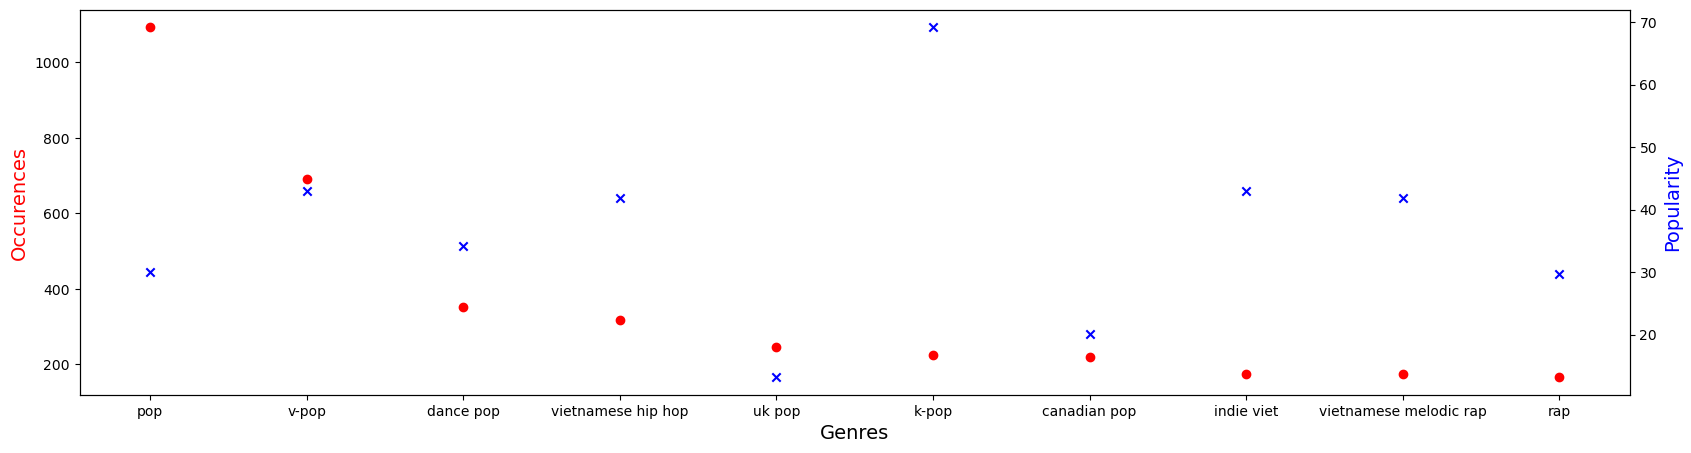

In [172]:
# genre_trend.plot.scatter(x='occurences', y='popularity', figsize=(20,5))
top10 = genre_trend.nlargest(n=10, columns=['occurences', 'popularity'])
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(top10.index, top10['occurences'], color='red', marker='o')
ax.set_xlabel("Genres", fontsize = 14)
ax.set_ylabel("Occurences", fontsize = 14, color='red')

ax2 = ax.twinx()
ax2.scatter(top10.index, top10['popularity'], color='blue', marker='x')
ax2.set_ylabel("Popularity", fontsize = 14, color='blue')

plt.show()

Now we coming to how we rate the genres.

We create a system of rating from 1-100 in which the rating point is calculated by square root of the result of multiplication between scaled number of occurence (1-100) and scaled popularity point(1-100).

First, we create a scaling function

In [173]:
def MinMaxScaler1_100(s):
    return (99*(s - s.min()))/(s.max()-s.min()) + 1

Seconly, we scale the occurences and population columns by the created function above and then change the columns' name.

In [174]:
genre_trend['occurences'] = MinMaxScaler1_100(genre_trend['occurences'])
genre_trend['popularity'] = MinMaxScaler1_100(genre_trend['popularity'])
genre_trend_table = genre_trend.rename(columns={'occurences': 'occurences_scaled', 'popularity': 'popularity_scaled'})

In [175]:
genre_trend_table.sort_values(by='occurences_scaled').round(2)

,occurences_scaled,popularity_scaled
genres,,
a cappella,1.00,78.00
ninja,1.00,80.20
electronic trap,1.00,84.60
nightcore,1.00,68.10
emoplugg,1.00,81.30
...,...,...
uk pop,23.30,15.51
vietnamese hip hop,29.65,47.08
dance pop,32.73,38.67


Thirdly, we calculate the correspoding rating point for all genres.

In [176]:
genre_trend_table['rating'] = np.sqrt(genre_trend_table['occurences_scaled'] * genre_trend_table['popularity_scaled'])
genre_trend_table['rating'] = MinMaxScaler1_100(genre_trend_table['rating'])
genre_trend_table.sort_values(by='rating').round(2)

,occurences_scaled,popularity_scaled,rating
genres,,,
nu disco,1.00,1.00,1.00
alternative pop rock,1.00,1.00,1.00
indie emo,1.00,1.00,1.00
queens hip hop,1.00,1.00,1.00
dark clubbing,1.09,1.00,1.08
...,...,...,...
dance pop,32.73,38.67,60.67
vietnamese hip hop,29.65,47.08,63.74
k-pop,21.22,77.08,69.05


In [177]:
genre_trend_table.nlargest(n=10, columns='rating').round(2)

,occurences_scaled,popularity_scaled,rating
genres,,,
pop,100.00,34.08,100.00
v-pop,63.55,48.21,94.79
k-pop,21.22,77.08,69.05
vietnamese hip hop,29.65,47.08,63.74
dance pop,32.73,38.67,60.67
indie viet,16.77,48.24,48.36
vietnamese melodic rap,16.68,47.06,47.62
k-pop boy group,8.89,78.86,44.95
k-pop girl group,7.26,80.28,40.92


The result is more clearly visualized by the below bar chart.

<AxesSubplot:ylabel='genres'>

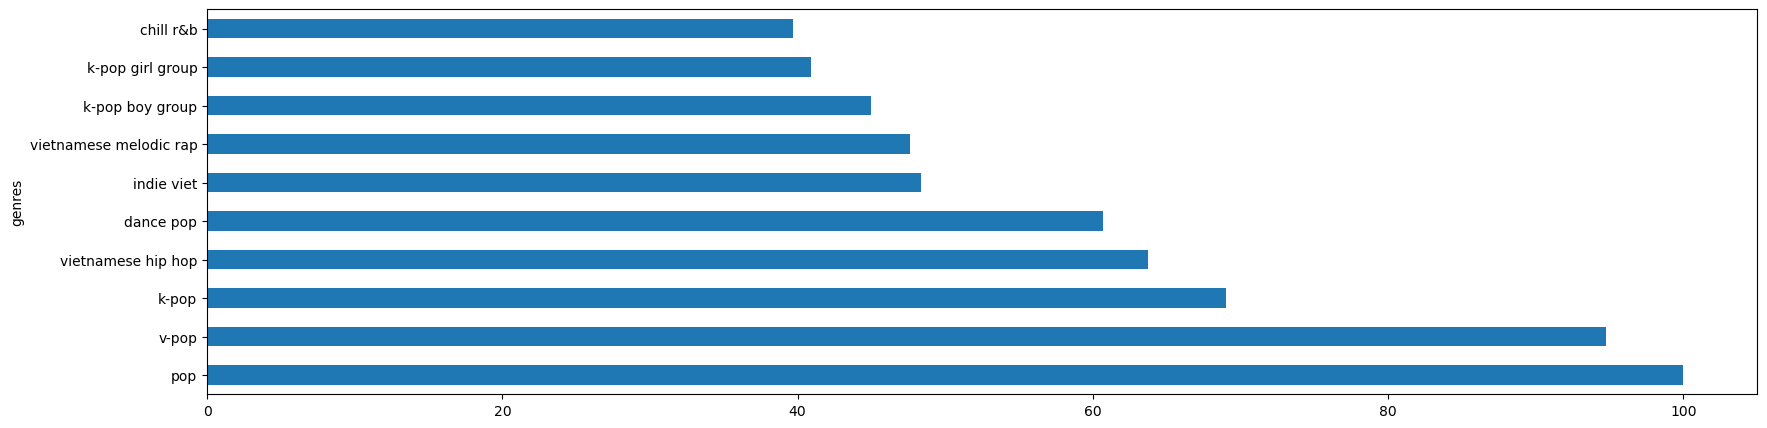

In [178]:
genre_trend_table.nlargest(n=10, columns='rating')['rating'].plot.barh(figsize=(20, 5))

Pop, V-Pop, K-Pop, Vietnamese hip hop, and dance pop are the top 5 best rated genres.

### <b><u>Question</u>: Gu âm nhạc thịnh hành nhất trong khoảng thời gian 3 năm ?</b>

The question is about the changes in the most popular music taste per each month each year in the last 3 years. 

Given this, the first thing we need to do is to examine the release month and year of each track in the dataset

In [179]:
df['month'] = df['released_date'].dt.month
df['year'] = df['released_date'].dt.year
df.head()

,id,name,artist,genres,artist_followers,artist_popularity,markets,album,released_date,album_popularity,duration,popularity,main_genre,artists_count,month,year
0,1RDvyOk4WtPCtoqciJwVn8,Dreamers [Music from the FIFA World Cup Qatar ...,"[Jung Kook, BTS, FIFA Sound]","[k-pop boy group, k-pop]",58961886,100,183,Dreamers [Music from the FIFA World Cup Qatar ...,2022-11-20,81,201391,92,k-pop boy group,3,11,2022
2,7bFFUPBiF15n8m8RziqS4o,dự báo thời tiết hôm nay mưa,[GREY D],[v-pop],39690,56,182,dự báo thời tiết hôm nay mưa – Maxi Single,2022-11-22,52,281493,62,v-pop,1,11,2022
3,4QjxvzEFwb63NZ1pp3wvHy,Chết Trong Em,[Thịnh Suy],"[vietnamese singer-songwriter, v-pop]",359817,54,183,Chết Trong Em,2022-10-31,50,256663,62,vietnamese singer-songwriter,1,10,2022
4,5p8ThxM2OhJ0igfxkz0Z1q,Wild Flower (with youjeen),[RM],[k-rap],12005881,81,183,Indigo,2022-12-02,85,273499,88,k-rap,1,12,2022
6,5yrPkBvOBvqfSjDhoRzDlO,Tại Vì Sao,[RPT MCK],"[vietnamese trap, vietnamese hip hop, vietname...",271841,56,183,Tại Vì Sao,2022-09-23,52,203111,64,vietnamese trap,1,9,2022


**To answer this question, we base on 2 factors, and each factor will give diffent results to each other.**

The first factor, popularity.

We will find the genre that has the highest popularity point of each month each year among the 3-year period.

In [180]:
song_release_df = df.explode('genres').loc[:, ['name', 'genres', 'popularity', 'year', 'month']].reset_index(drop=True)
genre_release = song_release_df.groupby(['year', 'month']).max()
genre_release

name                        genres  \
year month                                                                 
2020 1                          너를 사랑하고 있어                  vocal trance   
     2                                  시작                 zhongguo feng   
     3                                  少年                     weirdcore   
     4                                旧梦一场                     viral pop   
     5                                  情人               vietnamese trap   
     6                                爱,存在                     viral rap   
     7                                飞鸟和蝉  vietnamese singer-songwriter   
     8                                 燕无歇                     weirdcore   
     9                                 起风了                     viral pop   
     10                                紅蓮華                  zhenskiy rep   
     11                          parachute                     viral pop   
     12                                沈园外                 zhongguo feng   
2021 1                                  群青                     viral rap   
     2                                  沦陷                west coast rap   
     3                                西楼别序                 zhongguo feng   
     4                     输入法打可爱按第五 - 纯享版                     viral pop   
     5                                  不如                     viral rap   
     6                              好きだから。                   white noise   
     7                                飞鸟和蝉                     viral pop   
     8                                时光洪流                     viral rap   
     9                            Độ Tộc 2                     viral pop   
     10                         Đừng Bỏ Lỡ                   white noise   
     11                                踊り子                     viral rap   
     12                                 逆夢                     viral pop   
2022 1                            snowfall               vietnamese trap   
     2                 Đau Nhất Là Lặng Im               vietnamese trap   
     3         Trên Tình Bạn Dưới Tình Yêu  vietnamese singer-songwriter   
     4                            With you        vietnamese melodic rap   
     5      hai mươi hai (22) [feat. AMEE]        vietnamese melodic rap   
     6        vaicaunoicokhiennguoithaydoi                     viral pop   
     7                  Đã Lỡ Yêu Em Nhiều  vietnamese singer-songwriter   
     8                đứa nào làm em buồn?                west coast rap   
     9                    Đáp Án Cuối Cùng               vietnamese trap   
     10                        golden hour                     viral pop   
     11                           Đơn Giản                     viral pop   
     12       you should see me in a crown  vietnamese singer-songwriter   

            popularity  
year month              
2020 1              89  
     2              83  
     3              91  
     4              84  
     5              89  
     6              83  
     7              84  
     8              87  
     9              82  
     10             84  
     11             84  
     12             83  
2021 1              80  
     2              80  
     3              87  
     4              83  
     5              87  
     6              87  
     7              88  
     8              87  
     9              89  
     10             87  
     11             85  
     12             89  
2022 1              90  
     2              80  
     3              93  
     4              88  
     5              95  
     6              90  
     7              94  
     8              97  
     9             100  
     10             97  
     11             92  
     12             91

Then we will count the occurence of each unique genre in the above table.

The result of basing in popularity factor is shown by the below bar chart.

<AxesSubplot:>

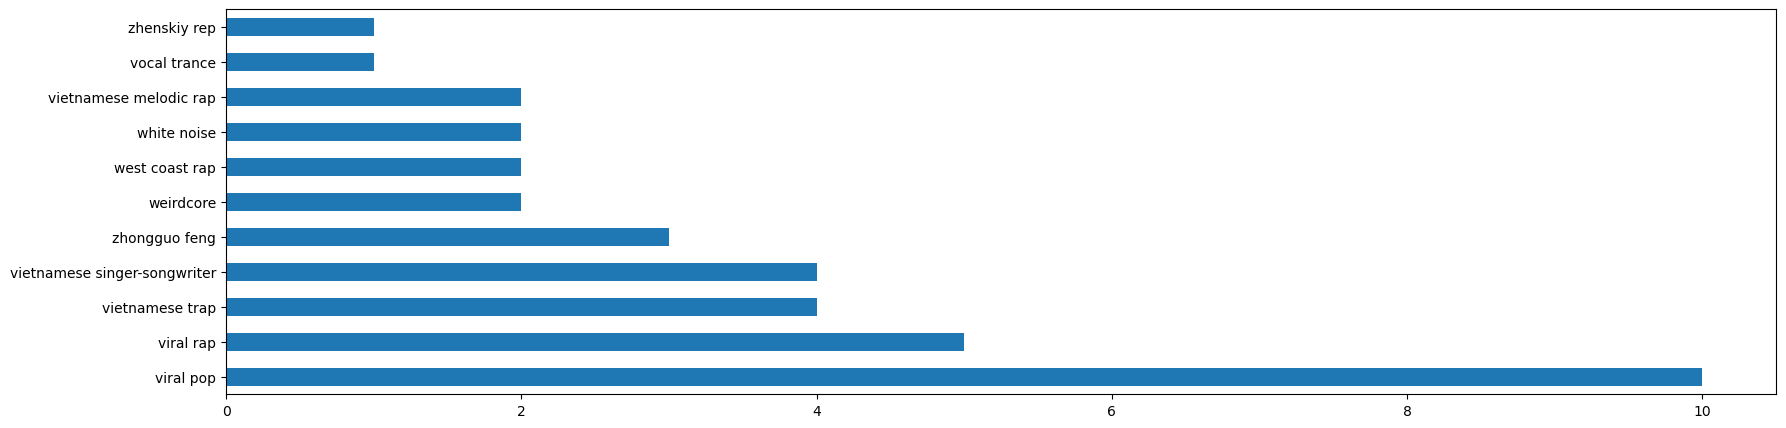

In [181]:
genre_release['genres'].value_counts().plot.barh(figsize=(20, 5))

As can be seen, viral pop appears to have the most highest popularity points among the period (10), which is follow by viral rap (5).

We now move to the second factor, number of occurence.

We will find the genre which has the highest number of occurence in each month of each year among the period.

In [182]:
genre_release_most = song_release_df.groupby(['year', 'month'])['genres'].agg(pd.Series.mode).to_frame()
genre_release_most

genres
year month                             
2020 1                            v-pop
     2                            k-pop
     3                              pop
     4                            v-pop
     5                            v-pop
     6                            v-pop
     7                            v-pop
     8                            v-pop
     9                            v-pop
     10                           v-pop
     11                           v-pop
     12                           v-pop
2021 1                            v-pop
     2                            v-pop
     3                            v-pop
     4                            v-pop
     5                            v-pop
     6                            v-pop
     7                     [pop, v-pop]
     8                            v-pop
     9                            v-pop
     10                             pop
     11                             pop
     12                           v-pop
2022 1      [v-pop, vietnamese hip hop]
     2                            v-pop
     3                            v-pop
     4                            v-pop
     5                            v-pop
     6                            v-pop
     7                            v-pop
     8                            v-pop
     9                            v-pop
     10                           v-pop
     11                           v-pop
     12                             pop

There are 2 months in which 2 genres have the same number of occurence. 

We will explode them and cover them in the final result, which is clearly visualized by the cbar chart below.

<AxesSubplot:ylabel='genres'>

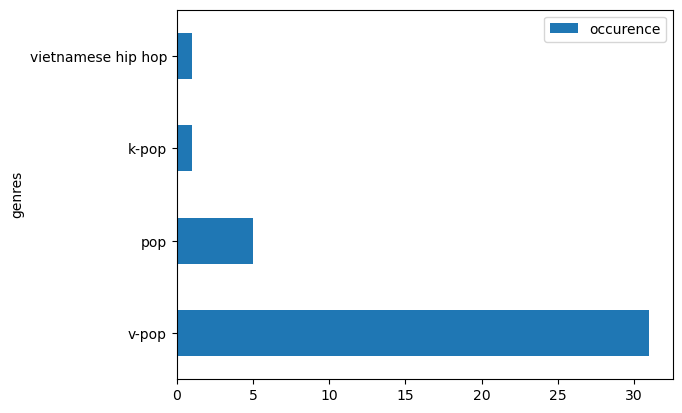

In [183]:
genre_release_most.explode('genres').value_counts().reset_index(name='occurence').plot.barh(x='genres', y='occurence')

As can be seen, this factor gives the result that pop is the most popular music taste with v-pop is chief among.

In conclusion, the results of examining by 2 aformentioned factors (popularity & number of occurence) can justifiably give that pop is the most popular music taste in the last 3 years.